# Transfer learning with PyTorch

This notebook is adapted from [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

**You will need to run this notebook in Google Colab. It is very slow to train without a GPU...**

> [**Open this notebook in Colab**](https://drive.google.com/open?id=1s8k_MRo8AKq5qXE_5XS-7LY-yjzHxC81)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
torch.__version__, torchvision.__version__

('1.3.1', '0.2.1')

In [3]:
# If you're on a machine with a CUDA GPU, you can use it.
# torch.cuda.get_device_name(torch.cuda.current_device())

## Data loading - GDrive

You will need to add this folder to your Google Drive: https://drive.google.com/drive/folders/14lrVjhBQP7z4eGP4mAQetPC-KD0a0RMo?usp=sharing

This next cell is for loading the data on Google Drive:

In [ ]:
import glob
from google.colab import drive

drive.mount('/content/gdrive')

len([f for f in glob.glob("/content/gdrive/My Drive/fossilnet/train/*/*.png")])

In [ ]:
from PIL import Image

img = Image.open('/content/gdrive/My Drive/fossilnet/train/ammonites/00001.png')
img

In [ ]:
data_dir = '/content/gdrive/My Drive/fossilnet'

## Data loading - Local

You can get the data here >> https://swung-data.s3.amazonaws.com/fossilnet/fossilnet-png-224px.zip

In [5]:
import glob
len([f for f in glob.glob("../data/fossils/fossilnet-png-224px/train/*/*")])

2000

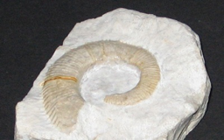

In [6]:
from PIL import Image

Image.open('../data/fossils/fossilnet-png-224px/train/ammonites/00001.png')

In [ ]:
data_dir = '../data/fossils/fossilnet-png-224px/'

## Data augmentation and normalization

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [15]:
class_names = image_datasets['train'].classes
class_names

['ammonites',
 'bivalves',
 'corals',
 'dinosaurs',
 'echinoderms',
 'fishes',
 'forams',
 'gastropods',
 'plants',
 'trilobites']

In [16]:
no_classes = len(class_names)
no_classes

10

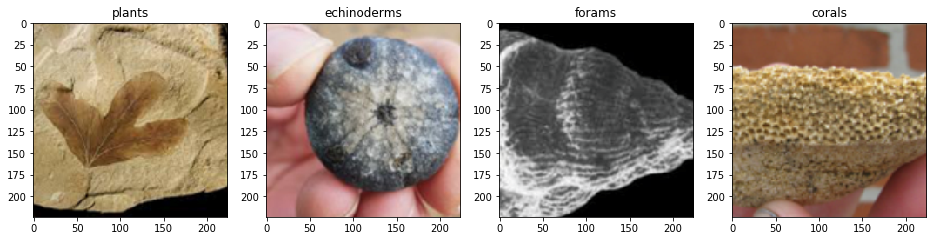

In [17]:
def imshow(inp, ax=None, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 2))
        return_ax = False
    else:
        return_ax = True
    im = ax.imshow(inp)
    if title is not None:
        ax.set_title(title)

    if return_ax:
        return ax
    else:
        return

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
#out = torchvision.utils.make_grid(inputs)
inputs = inputs.to(device)

fig, axs = plt.subplots(ncols=4, figsize=(16, 4))
for j in range(inputs.size()[0]):
    ax = imshow(inputs.cpu().data[j], ax=axs[j], title=class_names[classes[j]])

## Retrain the RESNET-18 model

A residual network is like an ordinary neural network, but with *skip connections*. In other words, a layer might get input not only from the previous layer, but from one or two layers before that. The original ResNet used this strategy with very deep networks with >150 layers; almost 10x deeper than VGG. [Read the original paper.](https://arxiv.org/pdf/1512.03385.pdf)

### The training function

This function looks pretty involved at first. Take a minute to read it. Here's what's happening:

- Loop over the epochs
- In the **train** phase:
  - Call `model.train()` to tell model we're training.
  - Do a forward pass.
  - Do back propagation (compute gradient and optimize).
  - Save the training loss.
- In the **val** phase:
  - Call `model.eval()` to tell the model we're evaluating.
  - Compute the accuracy.
  - If this is the best model so far, remember it.

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Initialize the 'best so far' variables.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Training loop.
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase.
        # We need to set the model 'mode'.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients.
                optimizer.zero_grad()

                # Forward pass.
                # Track history only if in train.
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backprop + optimize only if in train.
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # Statistics.
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Accuracy.
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model if it's the best so far.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Return best model weights.
    model.load_state_dict(best_model_wts)
    return model, train_loss, val_loss

## Set up the model: tune ALL parameters

This is where we set up the model. First we must download it (it is 44.7MB and will be cached on your machine). Then we adapt it to our task, set up the loss function and optimizer, and finally set up the learning rate decay.

In [19]:
# Instantiate the ResNet-18 model.
model_ft = models.resnet18(pretrained=True)

# Make the fully connection layer fit our task.
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, no_classes)

# Send to device.
model_ft = model_ft.to(device)

# Choose loss function.
criterion = nn.CrossEntropyLoss()

# Observe that *all* parameters are being optimized. (Compared to following example.)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Now we can actually train the model.

In [20]:
model_ft, train_loss, val_loss = train_model(model_ft,
                                             criterion,
                                             optimizer_ft,
                                             exp_lr_scheduler,
                                             num_epochs=10,
                                             )

Epoch 0/49
----------
train Loss: 2.4148 Acc: 0.1265
val Loss: 2.3995 Acc: 0.1360

Epoch 1/49
----------


KeyboardInterrupt: 

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

The training score is much higher than the validation score. The model seems to be somewhat overtrained.

Let's save the model to a file:

In [ ]:
torch.save(model_ft.state_dict(), '/content/gdrive/My Drive/fossilnet/fossilnet.pt')

## Visualize the results

In [100]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig, axs = plt.subplots(ncols=6, figsize=(18,3))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Get probabilities
            sm = torch.nn.Softmax()
            probs = sm(outputs)
            argsort = torch.argsort(probs, descending=True)
            
            for j in range(inputs.size()[0]):
                ax = axs[images_so_far]
                images_so_far += 1
                
                actual_class = class_names[labels[j]]
                pred_class = class_names[preds[j]]
                pred_prob = max(probs[j])
                
                # Could also do:
                # pred_class = class_names[argsort[j][0]],
                # pred_prob = probs[j][argsort[j][0]],                    

                if pred_prob > 99.9e-2:
                    ax.set_title('{}\n{} {:.3f}'.format(actual_class.upper(),
                                                        pred_class,
                                                        pred_prob,
                                                       ))
                else:
                    ax.set_title('{}\n{} {:.3f}\n{} {:.3f}'.format(actual_class.upper(),
                                                        pred_class,
                                                        pred_prob,
                                                        class_names[argsort[j][1]],
                                                        probs[j][argsort[j][1]],
                                                       ))
                ax.set_xticks([])
                ax.set_yticks([])

                c = 'green' if (actual_class == pred_class) else 'red'
                for spine in ax.spines.values():
                    spine.set_edgecolor(c)
                    spine.set_linewidth(4)

                ax = imshow(inputs.cpu().data[j], ax=ax)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

    return

/Users/matt/anaconda3/envs/deepl/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


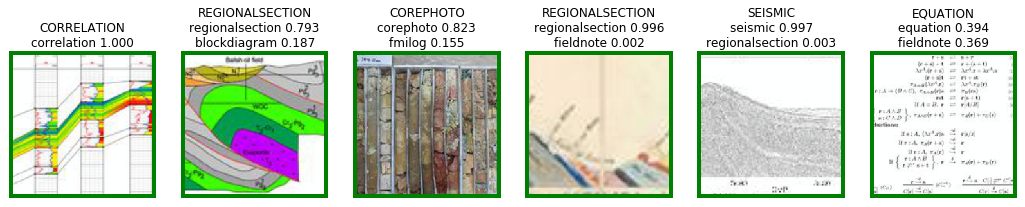

In [134]:
visualize_model(model_ft)

## Evaluating the model

You will need to step over the data, making predictions, and then comparing them to the validation set labels. 

Most people do the analysis (F1 score, confusion matrix, etc) in `scikit-learn`.

## Another approach: freeze convolutional layers

Instead of adjusting the weights in all the layers a little bit, we can choose to only train the last layer.

In [21]:
model_conv = torchvision.models.resnet18(pretrained=True)

# Turn off gradients for faster training.
for param in model_conv.parameters():
    param.requires_grad = False

# Newly constructed layers have requires_grad=True by default.
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, no_classes)

# Send to device.
model_conv = model_conv.to(device)

# Choose the loss function.
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
#                                   ^^^^^^

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [22]:
model_conv, train_loss, val_loss = train_model(model_conv,
                                               criterion,
                                               optimizer_conv,
                                               exp_lr_scheduler,
                                               num_epochs=10,
                                              )

Epoch 0/9
----------
train Loss: 2.3934 Acc: 0.1210
val Loss: 2.4474 Acc: 0.1140

Epoch 1/9
----------


KeyboardInterrupt: 

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

/Users/matt/anaconda3/envs/deepl/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


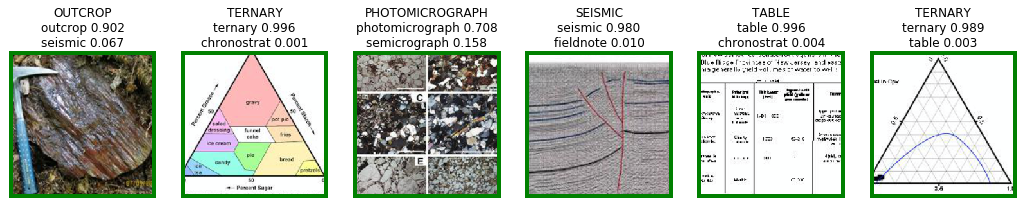

In [154]:
visualize_model(model_conv)

## Train entire network from scratch

We'd expect this model to perform poorly, and probably be undertrained.

In [ ]:
model_new = torchvision.models.resnet18(pretrained=False)  # Not trained is the default.

# Adapt the fc layer to our task.
num_ftrs = model_new.fc.in_features
model_new.fc = nn.Linear(num_ftrs, no_classes)

# Send to device.
model_new = model_new.to(device)

# Choose the loss function.
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_ft = optim.SGD(model_new.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_new, train_loss, val_loss = train_model(model_new,
                                              criterion,
                                              optimizer_ft,
                                              exp_lr_scheduler,
                                              num_epochs=20,
                                             )

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()